# FastSAM
<a target="frameName" href="https://colab.research.google.com/github/mora-bprs/sam-model/blob/main/fast-sam.ipynb">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="open stuff in google colab"/>
</a>

The following models are evaluated in this notebook to compare and contrast their efficacy to the bin picking task
1. SAM
2. FastSAM
2. FastSAM-s
<!-- TODO: add more details about the models -->

___
# 1. Environment Setup
---

In [6]:
import os

###############
COLAB = False  # True if Google Colab
###############
#####################
INITIALIZED = False  # False if running for the first time
#####################
######################
TESTING_SAM = True  # WIP: True if testing SAM, warn!: processing time and data usage
######################
OVERRIDE = False

# Other Configurations
#######################
DETAILED_LOGS = True  # True for detailed logs
DEFAULT_COLORS = False  # True for not overriding your colors
RESET_FASTSAM = False  # True to reset FastSAM repo
RESET_DATASET = False  # True to reset box_train dataset
RESET_WEIGHTS = False  # True to reset weights
#######################


os.system("pip install yachalk")

from yachalk import chalk as c  # noqa: E402

c.enable_full_colors()

by = c.bold.yellow_bright if DEFAULT_COLORS else c.bold.hex("#f0deb2")
br = c.bold.red_bright if DEFAULT_COLORS else c.bold.hex("#df8ca4")
bg = c.bold.green_bright if DEFAULT_COLORS else c.bold.hex("#abd6a0")
bb = c.bold.blue_bright if DEFAULT_COLORS else c.bold.hex("#92b3f4")
bm = c.bold.magenta_bright if DEFAULT_COLORS else c.bold.hex("#dcb6d6")
bc = c.bold.cyan_bright if DEFAULT_COLORS else c.bold.hex("#9cdae9")
bp = c.bold.hex("#c5a7f2")


def log(*args):
    if DETAILED_LOGS:
        print(bc("log:"), *args)


ROOT = os.getcwd()
if os.getcwd() == "/content" and not COLAB:
    if not OVERRIDE:
        log(br("possible environment misconfiguration"))
        log(bb("identified /content as the root which is generally the case for colab"))
        log(by("but COLAB set to False"))
        log(bg("if you wish to override this behavior set the OVERRIDE to True"))
        raise UserWarning()

print(br("--------------------------------------------"))
print(by("Google Colab") if COLAB else bm("Local"), "Environment Configured")
print(bc("Working Directory:"), ROOT)
print(br("--------------------------------------------"))

--------------------------------------------
Local Environment Configured
Working Directory: /Users/tony/arc/pro/dev/binpick-sam
--------------------------------------------



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
if not INITIALIZED:
    # check for requirements file and get it if not present
    if not os.path.exists("requirements.txt"):
        log(br("requirements file not found:"), bb("downloading"))
        if not os.system(
            "wget https://raw.githubusercontent.com/thuvasooriya/binpick-sam/main/requirements.txt"
        ):
            log(bg("requirements file downloaded"))
        else:
            raise RuntimeError  # likely to fail due to link failing
    if not os.system("pip install -r requirements.txt"):
        log(bg("requirements installed"))
    if TESTING_SAM:
        log(bg("opted to test SAM: installing SAM dependencies"))
        if not os.system("pip install onnx onnxruntime segment-anything"):
            log(bg("onnx, onnxruntime and segment-anything installed"))
else:
    if not os.path.exists("requirements.txt") or not OVERRIDE:
        log(br("requirements file not found but INITIALIZED set to True"))
        log(bb("if this is the expected behavior set OVERRIDE to True"))
        raise UserWarning()
    log(
        br("skipping:"),
        by("INITIALIZED set to", INITIALIZED),
        bg("dependencies already installed"),
    )

INFO: pip is looking at multiple versions of ipython to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ipython to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.2/808.2 kB 411.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 kB 598.7 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: prompt_toolkit
    Found existing installation: prompt-toolkit 3.0.43
    Uninstalling prompt-toolkit-3.0.43:
      Successfully uninstalled prompt-toolkit-3.0.43
  Attempting uninstall: ipython
    Found existing installation: ipython 8.24.0
    Uninstalling ipython-8.24.0:
      Successfully uninstalled ipython-8.24.0
log: requirements installed



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import cv2
import torch
import torchvision

print(f"{by('PyTorch')} v{torch.__version__}")
print(f"{by('Torchvision')} v{torchvision.__version__}")
print(f"{by('OpenCV')} v{cv2.__version__}")
CUDA = torch.cuda.is_available()
MPS = torch.backends.mps.is_available()
print(f"{bg('CUDA')} Available: {bg(CUDA) if CUDA else br(CUDA)}")
print(f"{bb('MPS')} Available: {bg(MPS) if MPS else br(MPS)}")

PyTorch v2.3.0
Torchvision v0.18.0
OpenCV v4.9.0
CUDA Available: False
MPS Available: True


## Test dataset setup

In [7]:
import shutil

import gdown

if not os.path.exists("train") or RESET_DATASET:
    shutil.rmtree("train", ignore_errors=True)
    gdown.download(
        "https://drive.google.com/uc?id=1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc",
        "box_train.zip",
        quiet=False,
    )
    os.system("unzip box_train.zip")
    os.remove("box_train.zip")
else:
    print(bg("skipping: dataset already downloaded"))

DATASET_PATH = f"{ROOT}/train"

if not os.path.exists(f"{ROOT}/annotate"):
    os.mkdir(f"{ROOT}/annotate")

skipping: dataset already downloaded


## Pretrained weights setup

In [8]:
### downloading FastSAM, SAM weights (pretrained model checkpoints)
# TODO: provide links to references and more details on the models


if RESET_WEIGHTS:
    if os.path.exists("weights/FastSAM-s.pt"):
        os.remove("weights/FastSAM-s.pt")
    if os.path.exists("weights/FastSAM-x.pt"):
        os.remove("weights/FastSAM-x.pt")
    if os.path.exists("weights/sam_vit_h_4b8939.pt"):
        os.remove("weights/sam_vit_h_4b8939.pt")
if not os.path.exists(f"{ROOT}/weights"):
    os.mkdir(f"{ROOT}/weights")
if not os.path.exists("weights/FastSAM-s.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV",
        "weights/FastSAM-s.pt",
        quiet=False,
    )
if not os.path.exists("weights/FastSAM-x.pt"):
    gdown.download(
        "https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv",
        "weights/FastSAM-x.pt",
        quiet=False,
    )
print(bg("FastSAM Weights Configured"))

if TESTING_SAM:
    if not os.path.exists("weights/sam_vit_h_4b8939.pth"):
        print(br("Downloading SAM weights (this may take a while...)"))
        if not os.system(
            "wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights/"
        ):
            print(bg("SAM weights downloaded"))
    else:
        print(by("skipping: SAM weights already downloaded"))

FastSAM Weights Configured
skipping: SAM weights already downloaded


In [29]:
from fastsam import FastSAM

# device = "cuda" if CUDA else "cpu"
# we do not need gpu for FastSAM
device = "cpu"

# YOLOv8x-seg
model_fastsam_x = FastSAM(f"{ROOT}/weights/FastSAM-x.pt")
log(by("FastSAM-x model loaded"))
model_fastsam_x.to(device)
model_fastsam_x.info()

# YOLOv8s-seg
model_fastsam_s = FastSAM(f"{ROOT}/weights/FastSAM-s.pt")
log(by("FastSAM-s model loaded"))
model_fastsam_s.to(device)
model_fastsam_s.info()

print(by("FastSAM models loaded into"), bb(device))

if TESTING_SAM:
    from segment_anything import sam_model_registry

    sam_device = "cuda" if CUDA else "cpu"
    model_sam = sam_model_registry["vit_h"](f"{ROOT}/weights/sam_vit_h_4b8939.pth").to(
        sam_device
    )
    print(bp("SAM ViT model loaded into"), bg(sam_device))

YOLOv8x-seg summary: 401 layers, 72234149 parameters, 0 gradients
YOLOv8s-seg summary: 261 layers, 11790483 parameters, 0 gradients


log: FastSAM-x model loaded
log: FastSAM-s model loaded
FastSAM models loaded into cpu
SAM ViT model loaded into cpu


## Helper Functions

In [10]:
DETAILED_LOGS = True
TARGET_SIZE = 320 if TESTING_SAM else 960
TARGET_WIDTH = 480
TARGET_HEIGHT = 320
# TARGET_WIDTH = TARGET_SIZE
# TARGET_HEIGHT = TARGET_SIZE
FASTSAM_X = 0
FASTSAM_S = 1
SAM = 2  # WIP
RANDOM = 3
SAVE_PATH = f"{ROOT}/annotate/plt_img_{RANDOM}.jpg"

In [11]:
import numpy as np

################################
### General Utility Functions
################################


def crop_n_resize(img_path, t_width=TARGET_SIZE, t_height=TARGET_SIZE):
    """
    Crop the image to the desired aspect ratio and resize it to the target height and width using OpenCV.
    """
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    aspect_ratio = t_width / t_height
    init_ratio = w / h

    # determine whether to crop the width or height
    if init_ratio > aspect_ratio:
        # crop the width
        crop_width = int(h * aspect_ratio)
        x = (w - crop_width) // 2
        # y = 0
        cropped = img[:, x : x + crop_width]
    else:
        # crop the height
        crop_height = int(w / aspect_ratio)
        # x = 0
        y = (h - crop_height) // 2
        cropped = img[y : y + crop_height, :]

    resized = cv2.resize(cropped, (t_width, t_height))

    if DETAILED_LOGS:
        h_new, w_new = resized.shape[:2]
        log(f"{w}x{h} -> {w_new}x{h_new}")

    return resized


log(bg("crop_n_resize function loaded"))

# def square_crop_n_resize(img_path, target_size):
#     """
#     Crop and Resize the image to a square image of target_size using OpenCV
#     """
#     img = cv2.imread(img_path)
#     h, w = img.shape[:2]
#     min_dim = min(h, w)
#     x = (w - min_dim) // 2
#     y = (h - min_dim) // 2
#     cropped = img[y : y + min_dim, x : x + min_dim]
#     resized = cv2.resize(cropped, (target_size, target_size))
#     if DETAILED_LOGS:
#         h_new, w_new = resized.shape[:2]
#         log(f"{w}x{h} -> {w_new}x{h_new}")
#         # fig, ax = plt.subplots(1, 2, figsize=(10, 10))
#         # ax[0].imshow(img)
#         # ax[1].imshow(resized)
#         # plt.show()
#     return resized


def get_coords(image, pos=0):
    """Get the coordinates of the image from an OpenCV image object
    Will return the center coordinates by default

    Args:
        image (OpenCV image): just an image
        pos (int, optional): asking for the position we want to get the coordinates. Defaults to 0.

    Returns:
        numpy.ndarray: returns the numpy array of x and y coordinates
    """
    h, w = image.shape[:2]
    if pos == 0:
        # center
        coords = [int(w / 2), int(h / 2)]
        log(f"{bb('Center Coords...')} -> {coords}")
    elif pos == 1:
        # topleft
        coords = [int(w / 4), int(h / 4)]
        log(f"{bb('TopLeft Coords...')} -> {coords}")
    elif pos == 2:
        # top
        coords = [int(w / 2), int(h / 4)]
        log(f"{bb('Top Coords...')} -> {coords}")
    elif pos == 3:
        # topright
        coords = [int(3 * w / 4), int(h / 4)]
        log(f"{bb('TopRight Coords...')} -> {coords}")
    elif pos == 4:
        # right
        coords = [int(3 * w / 4), int(h / 2)]
        log(f"{bb('Right Coords...')} -> {coords}")
    elif pos == 5:
        # botright
        coords = [int(3 * w / 4), int(3 * h / 4)]
        log(f"{bb('BotRight Coords...')} -> {coords}")
    elif pos == 6:
        # bot
        coords = [int(w / 2), int(3 * h / 4)]
        log(f"{bb('Bot Coords...')} -> {coords}")
    elif pos == 7:
        # botleft
        coords = [int(w / 4), int(3 * h / 4)]
        log(f"{bb('BotLeft Coords...')} -> {coords}")
    elif pos == 8:
        # left
        coords = int(w / 4), int(h / 2)
        log(f"{bb('Left Coords...')} -> {coords}")
    return np.array(coords)


log(bg("get_coords function loaded"))


def list_img_paths(directory):
    """
    Returns a list of paths for all image files in a directory
    """
    img_ext = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]
    img_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in img_ext):
                img_files.append(os.path.join(root, file))
    return img_files


log(bg("list_img_paths function loaded"))

log: crop_n_resize function loaded
log: get_coords function loaded
log: list_img_paths function loaded


In [12]:
from fastsam import FastSAMPrompt
from matplotlib import pyplot as plt

if TESTING_SAM:
    from segment_anything import SamPredictor

################################
### Plotting Helper Functions
################################


def show_point(coords, label, ax, marker_size=240):
    """function to show given coordinates in a plot
    Args:
        coords (array): points to plot
        labels (int): TODO
        ax (Axis): corresponding axis
        marker_size (int, optional): to modify default marker size. Defaults to 320.
    """
    # log(br("show_points locals:"), locals())
    if label == 1:
        ax.scatter(
            *coords,
            color="#ff0022",
            marker="o",
            s=marker_size,
            edgecolor="white",
            linewidth=2,
        )
    elif label == 0:
        ax.scatter(
            *coords,
            color="#92b3f4",
            marker="o",
            s=marker_size,
            edgecolor="black",
            linewidth=2,
        )


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])])
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def validate_mask(
    mask,
    threshold=0.5,
    lim_width=TARGET_WIDTH,
    lim_height=TARGET_HEIGHT,
    return_coords=False,
):
    # find the indices where the mask is true
    true_indices = np.argwhere(mask)
    # get the bounding box of the true region
    top_l = np.min(true_indices, axis=0)
    bot_r = np.max(true_indices, axis=0)
    # calculate the width and height of the bounding box
    w = bot_r[1] - top_l[1]
    h = bot_r[0] - top_l[0]
    if return_coords:
        return [top_l, bot_r, w, h]


def get_box_from_mask(mask):
    # find the indices where the mask is true
    h, w = mask.shape[-2:]
    print(f"Mask Shape: {mask.shape[-2:]}")
    # mask = mask.reshape(h, w, 1)
    true_indices = np.argwhere(mask)
    log(f"True Indices: {true_indices}")
    # get the bounding box of the true region
    top_l = np.min(true_indices, axis=0)
    log(f"Top Left: {top_l}")
    bot_r = np.max(true_indices, axis=0)
    log(f"Bot Right: {bot_r}")
    # calculate the width and height of the bounding box
    w = bot_r[1] - top_l[1]
    h = bot_r[0] - top_l[0]

    # calculate the coordinates of the corners
    # top_r = (top_l[1] + w, top_l[0])
    # bot_l = (top_l[1], top_l[0] + h)
    # bot_r = (top_l[1] + w, top_l[0] + h)
    # top_l = (top_r[0] - (bot_r[0] - bot_l[0]), (top_r[1] - bot_r[1]) + bot_l[1])

    # log(f"Bounding Box: {top_l}, {top_r}, {bot_l}, {bot_r}")
    return [top_l, bot_r, w, h]


def show_box(box, ax, ec="green", fc="none", lw=2):
    x0, y0, w, h = box
    # x0, y0 = box[0], box[1]
    # w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=ec, facecolor=fc, lw=lw))


# def annotate_square_corners(
#     image, top_left, top_right, bottom_left, bottom_right, save_path
# ):
#     # Create a figure and axis
#     fig, ax = plt.subplots(1)

#     # Plot the original image
#     ax.imshow(image)

#     # Annotate the corners
#     ax.plot(top_left[0], top_left[1], "ro")  # Top Left corner
#     ax.plot(top_right[0], top_right[1], "go")  # Top Right corner
#     ax.plot(bottom_left[0], bottom_left[1], "bo")  # Bottom Left corner
#     ax.plot(bottom_right[0], bottom_right[1], "yo")  # Bottom Right corner

#     # Save the plot to the specified path
#     plt.savefig(save_path)
#     plt.show()


def model_prompter(
    img,
    model,
    retina_masks=True,
    img_width=TARGET_SIZE,
    conf=0.4,
    iou=0.9,
):
    if model == FASTSAM_X:
        return FastSAMPrompt(
            img,
            model_fastsam_x(
                img,
                device=device,
                retina_masks=retina_masks,
                imgsz=img_width,
                conf=conf,
                iou=iou,
            ),
            device=device,
        )
    elif model == FASTSAM_S:
        return FastSAMPrompt(
            img,
            model_fastsam_s(
                img,
                device=device,
                retina_masks=retina_masks,
                imgsz=img_width,
                conf=conf,
                iou=iou,
            ),
            device=device,
        )
    elif model == SAM and TESTING_SAM:
        sam_prompt = SamPredictor(model_sam)
        sam_prompt.set_image(img)
        return sam_prompt
    else:
        return "Invalid model"


def fastsam_maskgen(
    image,
    model,
    points=[[160, 160]],
    pointlabel=[1],
):
    """
    utility function to easily generate masks from FastSAM models
    """
    # log(br("fastsam_maskgen_locals:"), locals())
    if model == FASTSAM_X:
        return model_prompter(image, FASTSAM_X).point_prompt(
            np.array(points), np.array(pointlabel)
        )
    elif model == FASTSAM_S:
        return model_prompter(image, FASTSAM_S).point_prompt(
            np.array(points), np.array(pointlabel)
        )
    # elif model == SAM:
    #     return model_prompter(image, SAM).point_prompt(
    #         np.array(points), np.array(pointlabel)
    #     )
    else:
        return "Invalid model"


def plt_images(
    images,
    cols=2,
    axis="off",
    titles=None,
    mask=False,
    model=None,
    override_masks=None,
    coords=False,
    coords_pos=0,
    plt_box=False,
    save_fig=False,
    save_path=SAVE_PATH,
):
    if not isinstance(images, list):
        raise TypeError(
            "The 'images' argument must be a list of images. Consider using [image] if you have a single image."
        )
    # log(br("plt_images locals:"), locals())
    n_images = len(images)
    cols = min(n_images, cols)
    rows = n_images // cols + (1 if n_images % cols else 0)
    log(f"plotting {bb(n_images)} images in {rows}x{cols} grid")
    fig, ax = plt.subplots(rows, cols)
    fig.set_size_inches(
        10 * TARGET_WIDTH / TARGET_HEIGHT, rows * 10 / cols, forward=True
    )
    ax = ax.flatten() if n_images > 1 else [ax]
    for i in range(cols * rows):
        ax[i].axis(axis)
        if i < n_images:
            ax[i].imshow(images[i])
            point = get_coords(images[i], coords_pos)
            if coords:
                show_point(point, 1, ax[i])
            if mask:
                if override_masks:
                    show_mask(override_masks[i], ax[i])
                else:
                    mask_i = fastsam_maskgen(images[i], model, points=[point])
                    show_mask(
                        mask_i,
                        ax[i],
                    )
                    if plt_box:
                        show_box(
                            get_box_from_mask(mask_i),
                            ax[i],
                        )

            if titles:
                ax[i].set_title(titles[i])
    if save_fig:
        plt.savefig(save_path)
    plt.show()

In [13]:
################################
### Model Interface Functions
################################


# def get_mask_with_highest_score(masks, scores, logits):
#     # Ensure that masks, scores, and logits are numpy arrays
#     masks = np.array(masks)
#     scores = np.array(scores)
#     logits = np.array(logits)

#     # Find the index of the mask with the highest score
#     max_score_index = np.argmax(scores)

#     # Get the mask with the highest score
#     mask_with_highest_score = masks[max_score_index]

#     # Get the score and logits corresponding to the highest score
#     highest_score = scores[max_score_index]
#     logits_for_highest_score = logits[max_score_index]

#     return mask_with_highest_score, highest_score, logits_for_highest_score


# def plot_mask_with_score(image, title, mask, score, input_point, input_label):
#     plt.figure(figsize=(10, 10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {title}, Score: {score:.3f}", fontsize=18)
#     plt.axis("off")
#     plt.show()


# def plot_images_with_mask(model, image1, image2, image3, image4):
#     fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#     ax[0, 0].imshow(image1)
#     ax[0, 0].imshow(fastsam_maskgen(model, image1), alpha=0.5)
#     ax[0, 1].imshow(image2)
#     ax[0, 1].imshow(fastsam_maskgen(model, image2), alpha=0.5)
#     ax[1, 0].imshow(image3)
#     ax[1, 0].imshow(fastsam_maskgen(model, image3), alpha=0.5)
#     ax[1, 1].imshow(image4)
#     ax[1, 1].imshow(fastsam_maskgen(model, image4), alpha=0.5)
#     plt.show()


# def plot_diff_masks(image, m1, m2):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 10))
#     ax[0].imshow(image)
#     ax[0].imshow(fastsam_maskgen(m1, image), alpha=0.5)
#     ax[0].set_title("FastSAM-x", fontsize=18)
#     ax[0].axis("off")
#     ax[1].imshow(image)
#     ax[1].imshow(fastsam_maskgen(m2, image), alpha=0.5)
#     ax[1].set_title("FastSAM-s", fontsize=18)
#     ax[1].axis("off")

#     plt.show()


print(bg("Functions All Set! Ready to go!"))

Functions All Set! Ready to go!


## Preparing Test Set

In [14]:
# getting all image paths in the box_train dataset
IMG_PATHS = list_img_paths(DATASET_PATH)
IMG_COUNT = len(IMG_PATHS)
log(f"{bb(IMG_COUNT)} images found in the dataset")

# cropping and resizing all images to TARGET_SIZE and appending to img_arr
img_arr = []
TARGET_WIDTH = 480
TARGET_HEIGHT = 320
# TARGET_WIDTH = TARGET_SIZE
# TARGET_HEIGHT = TARGET_SIZE
for i, img_pth in enumerate(IMG_PATHS):
    img_arr.append(crop_n_resize(img_pth, TARGET_WIDTH, TARGET_HEIGHT))
    img_arr[i] = cv2.cvtColor(img_arr[i], cv2.COLOR_BGR2RGB)
print(
    f"{bg(len(img_arr))} images cropped and resized to {br(TARGET_WIDTH,'x', TARGET_HEIGHT)}"
)

# collection of 10 random guesses for the demo
WILD_GUESSES = np.random.randint(IMG_COUNT, size=10)
log(bc("10 Random Guesses Collected: "), by(*WILD_GUESSES))

log: 111 images found in the dataset
log: 225x225 -> 480x320
log: 225x225 -> 480x320
log: 1023x676 -> 480x320
log: 866x1390 -> 480x320
log: 581x849 -> 480x320
log: 543x600 -> 480x320
log: 1300x1390 -> 480x320
log: 299x168 -> 480x320
log: 275x183 -> 480x320
log: 272x185 -> 480x320
log: 301x167 -> 480x320
log: 275x183 -> 480x320
log: 225x225 -> 480x320
log: 600x527 -> 480x320
log: 1300x956 -> 480x320
log: 686x511 -> 480x320
log: 1300x924 -> 480x320
log: 350x180 -> 480x320
log: 472x878 -> 480x320
log: 194x259 -> 480x320
log: 275x183 -> 480x320
log: 300x168 -> 480x320
log: 179x282 -> 480x320
log: 264x191 -> 480x320
log: 300x168 -> 480x320
log: 956x452 -> 480x320
log: 339x251 -> 480x320
log: 275x183 -> 480x320
log: 1300x956 -> 480x320
log: 540x360 -> 480x320
log: 289x175 -> 480x320
log: 1024x678 -> 480x320
log: 1023x930 -> 480x320
log: 225x225 -> 480x320
log: 275x183 -> 480x320
log: 281x179 -> 480x320
log: 299x168 -> 480x320
log: 1300x956 -> 480x320
log: 600x510 -> 480x320
log: 611x594 -> 4

log: testing 480 x 320 images from 25 to 29
log: plotting 4 images in 2x2 grid
log: Center Coords... -> [240, 160]
log: Center Coords... -> [240, 160]
log: Center Coords... -> [240, 160]
log: Center Coords... -> [240, 160]


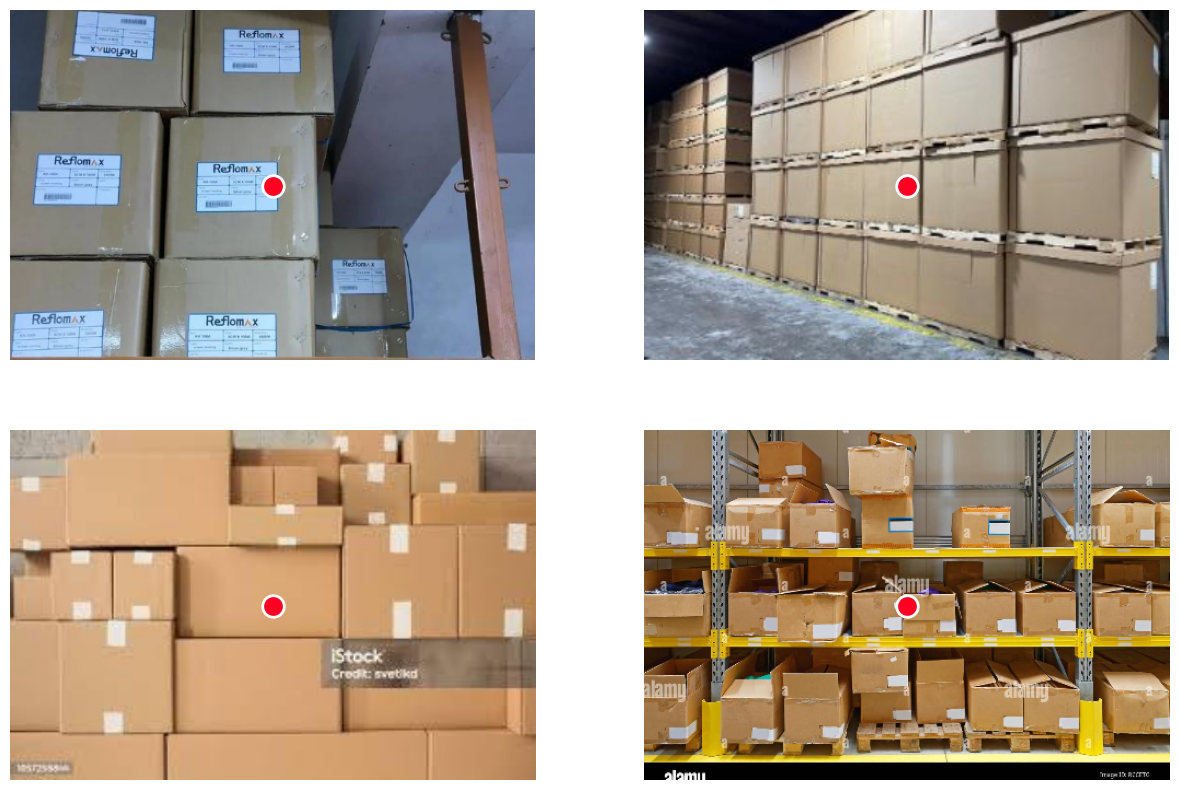

In [15]:
TEST_START = WILD_GUESSES[np.random.randint(10)]
# TEST_START = 71
TEST_RANGE = 4
TEST_IMG_LIST = img_arr[TEST_START : TEST_START + TEST_RANGE]
PLOT_COLS = 2

log(
    "testing",
    bb(TARGET_WIDTH, "x", TARGET_HEIGHT),
    "images from",
    bc(TEST_START, "to", TEST_START + TEST_RANGE),
)

# for i in range(9):
#     plt_images(
#         TEST_IMG_LIST,
#         cols=5,
#         coords=True,
#         coords_pos=i,
#     )

plt_images(
    TEST_IMG_LIST,
    cols=PLOT_COLS,
    coords=True,
    coords_pos=0,
)

___
# 2. Evaluating Models
---

## Evaluating FastSAM-x

log: FastSAM-x evaluation...
log: plotting 4 images in 2x2 grid
log: Center Coords... -> [240, 160]



0: 224x320 23 objects, 188.8ms
Speed: 2.3ms preprocess, 188.8ms inference, 20.6ms postprocess per image at shape (1, 3, 320, 320)

0: 224x320 29 objects, 131.8ms
Speed: 0.5ms preprocess, 131.8ms inference, 9.2ms postprocess per image at shape (1, 3, 320, 320)



log: Center Coords... -> [240, 160]
log: Center Coords... -> [240, 160]


0: 224x320 32 objects, 155.3ms
Speed: 0.8ms preprocess, 155.3ms inference, 8.5ms postprocess per image at shape (1, 3, 320, 320)

0: 224x320 70 objects, 131.5ms
Speed: 0.7ms preprocess, 131.5ms inference, 21.3ms postprocess per image at shape (1, 3, 320, 320)


log: Center Coords... -> [240, 160]


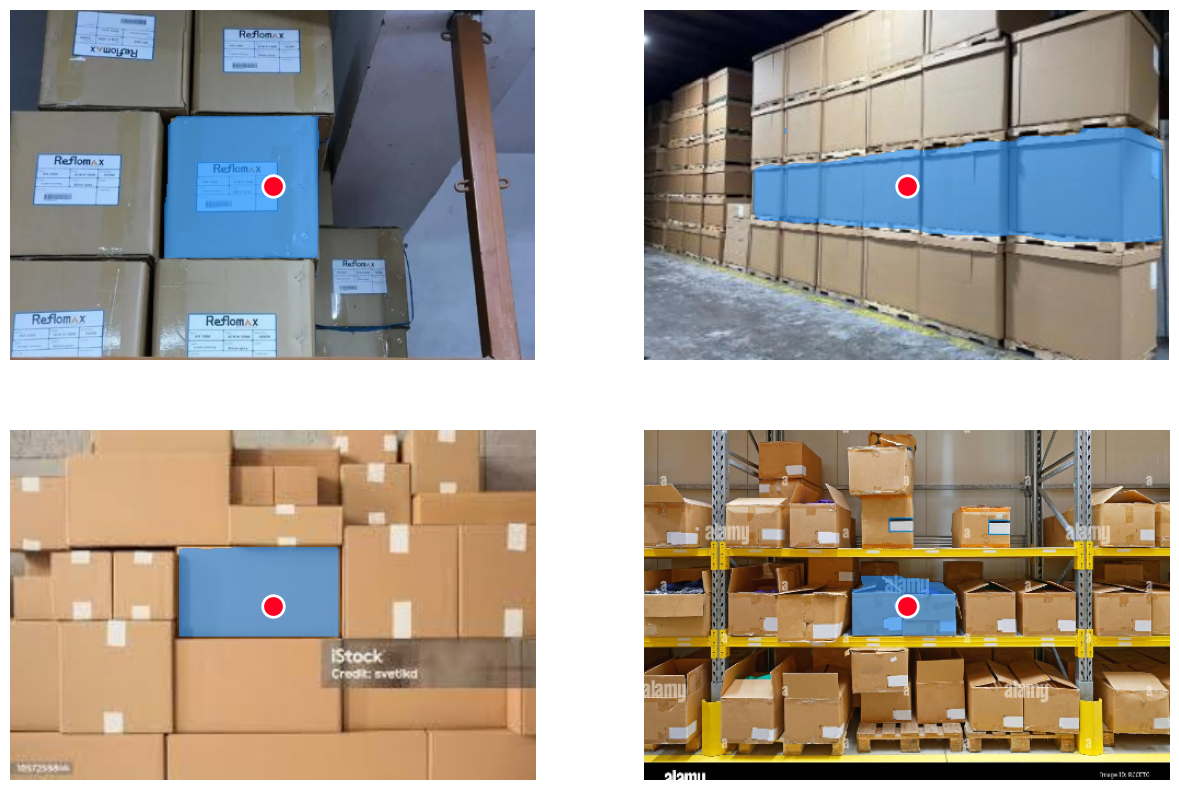

In [16]:
log(bg("FastSAM-x evaluation..."))

plt_images(
    TEST_IMG_LIST,
    cols=PLOT_COLS,
    coords=True,
    mask=True,
    plt_box=False,
    model=FASTSAM_X,
    coords_pos=0,
)

## Evaluating FastSAM-s

In [ ]:
# %timeit plt_images(TEST_IMG_LIST,mask=True, model=FASTSAM_S,)


0: 224x320 25 objects, 43.2ms
Speed: 0.6ms preprocess, 43.2ms inference, 7.0ms postprocess per image at shape (1, 3, 320, 320)



log: FastSAM-s evaluation...
log: plotting 4 images in 2x2 grid
log: TopLeft Coords... -> [120, 80]
log: TopLeft Coords... -> [120, 80]


0: 224x320 32 objects, 57.4ms
Speed: 0.9ms preprocess, 57.4ms inference, 9.8ms postprocess per image at shape (1, 3, 320, 320)

0: 224x320 39 objects, 48.9ms
Speed: 0.9ms preprocess, 48.9ms inference, 8.0ms postprocess per image at shape (1, 3, 320, 320)

0: 224x320 80 objects, 32.4ms
Speed: 0.5ms preprocess, 32.4ms inference, 18.6ms postprocess per image at shape (1, 3, 320, 320)


log: TopLeft Coords... -> [120, 80]
log: TopLeft Coords... -> [120, 80]


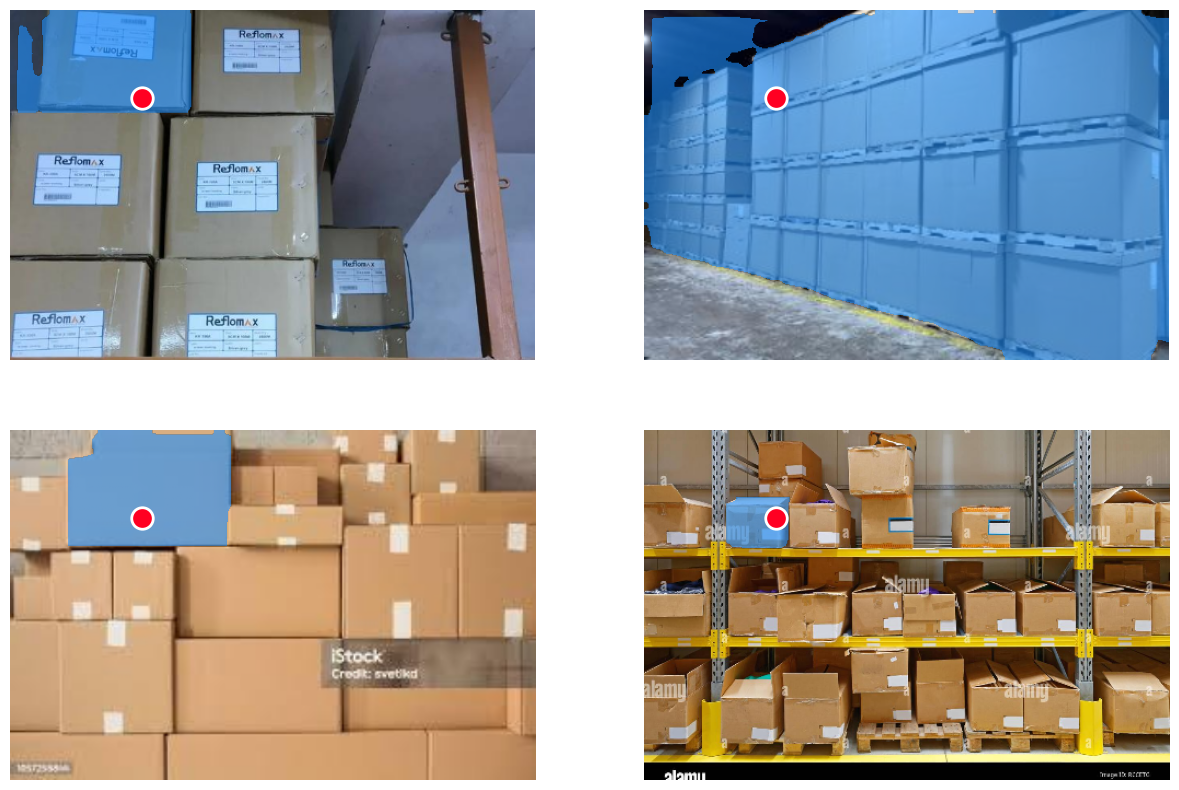

In [17]:
log(bg("FastSAM-s evaluation..."))
plt_images(
    TEST_IMG_LIST, cols=PLOT_COLS, coords=True, mask=True, model=FASTSAM_S, coords_pos=1
)

## Evaluating SAM: WIP

In [ ]:
# def plot_mask_with_score(image, title, mask, score, input_point, input_label):
#     plt.figure(figsize=(10, 10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {title}, Score: {score:.3f}", fontsize=18)
#     plt.axis("off")
#     plt.show()

# point prompt
# points default [[0,0]] [[x1,y1],[x2,y2]]
# point_label default [0] [1,0] 0:background, 1:foreground
# img_mask = fast_sam_prompt_process.point_prompt(
#     points=input_point, pointlabel=input_label
# )

# plot_mask_with_score(img, "FastSAM output", img_mask, input_point, input_label )


# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plot_mask_with_score(image, i + 1, mask, score, input_point, input_label)

In [ ]:
if TESTING_SAM:
    TEST_START = WILD_GUESSES[np.random.randint(10)]
    # TEST_START = 71
    TEST_RANGE = 2
    TEST_IMG_LIST = img_arr[TEST_START : TEST_START + TEST_RANGE]
    TEST_IMG = TEST_IMG_LIST[0]

    mask_x = model_prompter(TEST_IMG, FASTSAM_X).point_prompt(
        np.array([[160, 160]]), np.array([1])
    )

    s_mask = model_prompter(TEST_IMG, FASTSAM_S).point_prompt(
        np.array([[120, 120]]), np.array([1])
    )

    sam_mask, scores, logits = model_prompter(TEST_IMG, SAM).predict(
        point_coords=np.array([160, 160]),
        point_labels=np.array([1]),
        multimask_output=True,
    )
    # print(mask.shape)
    log(s_mask.shape)
    log(mask_x.shape)
    log(sam_mask.shape)
    # log(mask.shape[-2:])
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    # o, h, w = mask.shape[-2:]
    o, h, w = mask_x.shape
    reshaped_mask = mask_x.reshape(h, w, o) * color.reshape(1, 1, -1)
    log(reshaped_mask.shape)
    # log(reshaped_mask)
    reshaped_s_mask = s_mask.reshape(h, w, o) * color.reshape(1, 1, -1)
    log(reshaped_s_mask.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(TEST_IMG)
    plt.imshow(reshaped_mask)
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(TEST_IMG)
    plt.imshow(reshaped_s_mask)
    plt.show()
    center_coords = get_coords(TEST_IMG)
    log(TEST_IMG.shape)
    log(bg("SAM evaluation..."))
    sam_predictor = SamPredictor(model_sam)
    sam_predictor.set_image(TEST_IMG)
    masks, scores, logits = sam_predictor.predict(
        point_coords=np.array([center_coords]),
        point_labels=np.array([1]),
        multimask_output=True,
    )
    # plot the SAM mask over the image without using user defined functions
    # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # ax.imshow(TEST_IMG)
    # show_mask(masks[0], ax)
    # show_points(center_coords, np.array([1]), ax)
    # plt.show()
    #     predictor.set_image(img)

    #     img_masks, img_masks_scores, img_masks_logits = predictor.predict(
    #         point_coords=input_point,
    #         point_labels=input_label,
    #         multimask_output=True,
    #     )

    # plt_images([TEST_IMG, TEST_IMG], mask=True, override_masks=[masks[0], masks[1]])

    print(masks.shape)  # (number_of_masks) x H x W
    # color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    # o, h, w = mask.shape[-2:]
    # o, h, w = masks.shape
    # reshaped_mask = masks.reshape(h, w, o) * color.reshape(1, 1, -1)
    # log(reshaped_mask.shape)
    # print(fastsam_mask.shape)

    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     plot_mask_with_score(image, i + 1, mask, score, input_point, input_label)

    # mask_with_highest_score, highest_score, logits_for_highest_score = (
    #     get_mask_with_highest_score(masks, scores, logits)
    # )

    # plot_mask_with_score(
    #     image, "best", mask_with_highest_score, highest_score, input_point, input_label
    # )

---
# Comparing FastSAM-x and FastSAM-s
---

In [ ]:
# x_mask = fastsam_maskgen(0, img_arr[0])
# s_mask = fastsam_maskgen(1, img_arr[0])

# # ANNOTATED_PATH = f"{ROOT}/annotate/box.jpg"
# # BUG: tkinter kernel crash, unexpected behavior
# # fast_sam_prompt_process.plot(annotations=mask,output_path=ANNOTATED_PATH)

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(x_mask, interpolation="none")
# ax[1].imshow(s_mask, interpolation="none")
# # show_mask(x_mask, ax[0])
# # show_mask(s_mask, ax[1])
# plt.show()


# TODO: utilize show_mask function to plot the masks
# for i in range(4):
#     plot_diff_masks(img_arr[i], 0, 1)

---
# Coordinate Detections
---

In [ ]:
TEST_START = WILD_GUESSES[np.random.randint(10)]
# TEST_START = 71
TEST_RANGE = 4
TEST_IMG_LIST = img_arr[TEST_START : TEST_START + TEST_RANGE]
TEST_IMG = TEST_IMG_LIST[0]

TEST_MASK = fastsam_maskgen(TEST_IMG, FASTSAM_S, points=[get_coords(TEST_IMG, pos=3)])


log(f"""Testing {bb(TARGET_SIZE, "x", TARGET_SIZE)} images from {bc(TEST_START)} to {bc(TEST_START + TEST_RANGE)}
     Image Array Element Type: {type(TEST_IMG)}
     Image Array Element Shape: {TEST_IMG.shape}
     Sample Mask Type: {type(TEST_MASK)}
     Sample Mask Shape: {TEST_MASK.shape}
""")

log(get_box_from_mask(TEST_MASK))

In [ ]:
# plot_square(TEST_MASK)
# bound_coords = get_bounding_box_coordinates(TEST_MASK)
# annotate_square_corners(
#     TEST_IMG,
#     *get_bounding_box_coordinates(TEST_MASK),
#     f"{ROOT}/annotate/box_img_{TEST_START}.jpg",
# )

___
# Benchmarking
___

In [39]:
# getting all image paths in the box_train dataset
TEST_DATASET_PATH = f"{ROOT}/test_data"
TEST_IMG_PATHS = list_img_paths(TEST_DATASET_PATH)
log(f"{bb(len(TEST_IMG_PATHS))} images found in the test dataset")

# cropping and resizing all images to TARGET_SIZE and appending to img_arr
test_img_arr = []
TARGET_WIDTH = 480
TARGET_HEIGHT = 320
# TARGET_WIDTH = TARGET_SIZE
# TARGET_HEIGHT = TARGET_SIZE
for i, img_pth in enumerate(TEST_IMG_PATHS):
    # test_img_arr.append(cv2.imread(img_pth))
    test_img_arr.append(crop_n_resize(img_pth, TARGET_WIDTH, TARGET_HEIGHT))
    test_img_arr[i] = cv2.cvtColor(test_img_arr[i], cv2.COLOR_BGR2RGB)
# print(
#     f"{bg(len(test_img_arr))} images cropped and resized to {br(TARGET_WIDTH,'x', TARGET_HEIGHT)}"
# )

fast_sam_x_inference_times = []
fast_sam_x_mask_n_inference_times = []
fast_sam_s_inference_times = []
fast_sam_s_mask_n_inference_times = []
sam_inference_times = []
sam_mask_n_inference_times = []

log: 8 images found in the test dataset
log: 899x1599 -> 480x320
log: 899x1599 -> 480x320
log: 899x1599 -> 480x320
log: 899x1599 -> 480x320
log: 4080x2296 -> 480x320
log: 4080x2296 -> 480x320
log: 4080x2296 -> 480x320
log: 899x1599 -> 480x320


In [40]:
import time

from segment_anything import SamPredictor

POINT = [[160, 160]]


def measure_inference_mask_time(model, image):
    if isinstance(model, FastSAM):
        start_time = time.time()
        result = model(image, device="cuda" if torch.cuda.is_available() else "cpu")
        prompt_process = FastSAMPrompt(image, result)
        _ = prompt_process.point_prompt(points=POINT, pointlabel=[1])
        end_time = time.time()
    else:
        start_time = time.time()
        sam_predictor = SamPredictor(model)
        sam_predictor.set_image(image)
        sam_masks, _, _ = sam_predictor.predict(
            point_coords=np.array(POINT),
            point_labels=np.array([1]),
            multimask_output=True,
        )
        # below code for generate all masks
        # mask_generator = SamAutomaticMaskGenerator(model)
        # _ = mask_generator.generate(image)
        end_time = time.time()
    return end_time - start_time

In [41]:
for image in test_img_arr:
    try:
        # Measure FastSAM times
        time_x = measure_inference_mask_time(model_fastsam_x, image)
        log("time_x: ", time_x)
        fast_sam_x_inference_times.append(time_x)
        time_s = measure_inference_mask_time(model_fastsam_s, image)
        log("time_s: ", time_s)
        fast_sam_s_inference_times.append(time_s)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Image shape: {image.shape}")
        print(f"Image dtype: {image.dtype}")

for image in test_img_arr:
    try:
        # Measure SAM times
        time_sam = measure_inference_mask_time(model_sam, image)
        log("time_sam: ", time_sam)
        sam_inference_times.append(time_sam)
    except Exception as e:
        print(f"Error occurred: {e}")
        print(f"Image shape: {image.shape}")
        # print(f"Image dtype: {image.dtype}")


# Calculate averages
avg_fast_sam_x_inference = sum(fast_sam_x_inference_times) / len(
    fast_sam_x_inference_times
)
log("avg_x:", avg_fast_sam_x_inference)
avg_fast_sam_s_inference = sum(fast_sam_s_inference_times) / len(
    fast_sam_s_inference_times
)
log("avg_s:", avg_fast_sam_s_inference)
avg_sam_inference = sum(sam_inference_times) / len(sam_inference_times)
log("avg_sam:", avg_sam_inference)


0: 704x1024 23 objects, 1304.8ms
Speed: 8.5ms preprocess, 1304.8ms inference, 13.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 22 objects, 92.5ms
Speed: 1.4ms preprocess, 92.5ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


log: time_x:  1.9450559616088867


log: time_s:  0.2041637897491455


0: 704x1024 21 objects, 1115.2ms
Speed: 2.2ms preprocess, 1115.2ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 21 objects, 81.3ms
Speed: 0.9ms preprocess, 81.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)



log: time_x:  1.1506197452545166
log: time_s:  0.10045790672302246


0: 704x1024 18 objects, 994.6ms
Speed: 2.1ms preprocess, 994.6ms inference, 7.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 20 objects, 99.0ms
Speed: 1.2ms preprocess, 99.0ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)



log: time_x:  1.0256943702697754
log: time_s:  0.11634087562561035


0: 704x1024 13 objects, 1112.7ms
Speed: 2.1ms preprocess, 1112.7ms inference, 29.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 11 objects, 86.3ms
Speed: 2.1ms preprocess, 86.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)



log: time_x:  1.167212963104248
log: time_s:  0.10284805297851562


0: 704x1024 44 objects, 1074.5ms
Speed: 2.9ms preprocess, 1074.5ms inference, 14.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 43 objects, 89.0ms
Speed: 0.9ms preprocess, 89.0ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)



log: time_x:  1.1316502094268799
log: time_s:  0.1118459701538086


0: 704x1024 45 objects, 1031.1ms
Speed: 2.6ms preprocess, 1031.1ms inference, 23.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 39 objects, 83.6ms
Speed: 0.8ms preprocess, 83.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



log: time_x:  1.1172070503234863
log: time_s:  0.10557985305786133


0: 704x1024 48 objects, 1066.7ms
Speed: 2.0ms preprocess, 1066.7ms inference, 20.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 49 objects, 90.2ms
Speed: 0.8ms preprocess, 90.2ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)



log: time_x:  1.1344578266143799
log: time_s:  0.12179398536682129


0: 704x1024 27 objects, 1025.0ms
Speed: 2.6ms preprocess, 1025.0ms inference, 12.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 448x640 27 objects, 88.8ms
Speed: 0.9ms preprocess, 88.8ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


log: time_x:  1.0766150951385498
log: time_s:  0.11052918434143066
log: time_sam:  11.57037091255188
log: time_sam:  11.183174848556519
log: time_sam:  10.49674105644226
log: time_sam:  9.454899072647095
log: time_sam:  11.286956071853638
log: time_sam:  9.118006706237793
log: time_sam:  10.282485008239746
log: time_sam:  10.285757303237915
avg_x: 1.2185641527175903
avg_s: 0.12169495224952698
avg_sam: 10.459798872470856


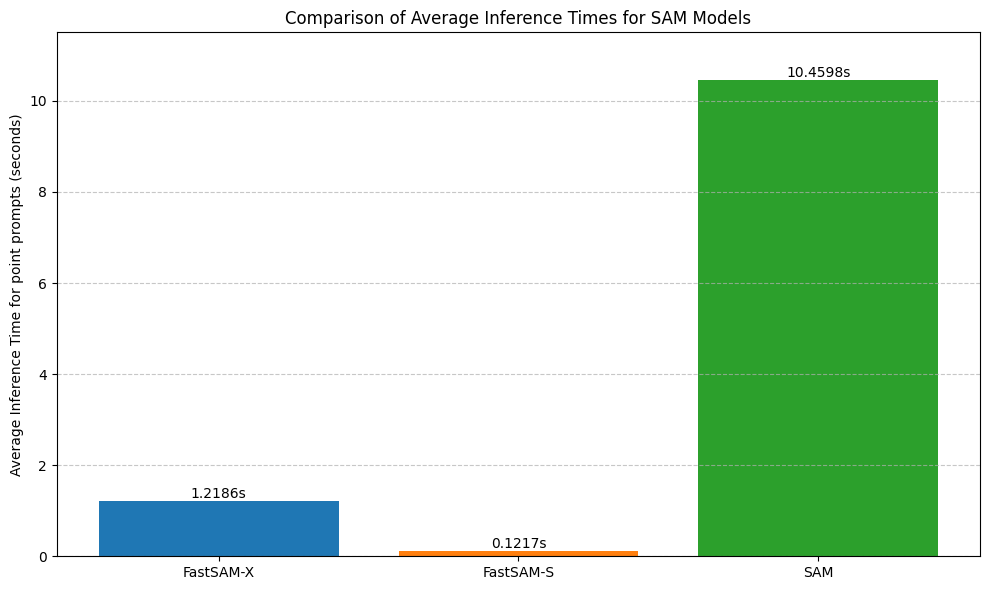

In [42]:
models = ["FastSAM-X", "FastSAM-S", "SAM"]
avg_times = [avg_fast_sam_x_inference, avg_fast_sam_s_inference, avg_sam_inference]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, avg_times, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

ax.set_ylabel("Average Inference Time for point prompts (seconds)")
ax.set_title("Comparison of Average Inference Times for SAM Models")
ax.set_ylim(
    0, max(avg_times) * 1.1
)  # Set y-axis limit to 110% of max value for better visibility

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.4f}s",
        ha="center",
        va="bottom",
    )

# Add a grid for better readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()